In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
import tempfile
import argparse
import math

In [36]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Data #

In [37]:
training_data = torch.load('Experiments/Foong_L1W50/Data/foong_data.pt')
x_train = training_data[0].to(device)
y_train = training_data[1].to(device)
y_train = y_train.unsqueeze(-1)

In [38]:
test_data = torch.load('Experiments/Foong_L1W50/Data/foong_data_test.pt')
x_test = test_data[0].to(device)
y_test = test_data[1].to(device)
y_test = y_test.unsqueeze(-1)

# Predictive Net #

In [39]:
input_dim=1
nblayers = 1
activation=nn.Tanh()
layerwidth = 50
param_count = (input_dim+1)*layerwidth+(nblayers-1)*(layerwidth**2+layerwidth)+layerwidth+1

In [40]:
def mlp(x,theta,input_dim=input_dim,layerwidth=layerwidth,nb_layers=nblayers,activation=activation):
    """
    Feedforward neural network used as the observation model for the likelihood
    

    Parameters:
        x (Tensor): Input of the network of size NbExemples X NbDimensions   
        theta (Tensor):  M set of parameters of the network NbModels X NbParam
        input_dim (Int): dimensions of NN's inputs (=NbDimensions)
        layerwidth (Int): Number of hidden units per layer 
        nb_layers (Int): Number of layers
        activation (Module/Function): activation function of the neural network

    Returns:
        Predictions (Tensor) with dimensions NbModels X NbExemples X NbDimensions


    Example:

    input_dim=11
    nblayers = 2
    activation=nn.Tanh()
    layerwidth = 20
    param_count = (input_dim+1)*layerwidth+(nblayers-1)*(layerwidth**2+layerwidth)+layerwidth+1

    x=torch.rand(3,input_dim)
    theta=torch.rand(5,param_count)
    mlp(x,theta,input_dim=input_dim,layerwidth=layerwidth,nb_layers=nblayers,activation=activation)

    """

    nb_theta=theta.shape[0]
    nb_x=x.shape[0]
    split_sizes=[input_dim*layerwidth]+[layerwidth]+[layerwidth**2,layerwidth]*(nb_layers-1)+[layerwidth,1]
    theta=theta.split(split_sizes,dim=1)
    input_x=x.view(nb_x,input_dim,1)
    m=torch.matmul(theta[0].view(nb_theta,1,layerwidth,input_dim),input_x)
    m=m.add(theta[1].reshape(nb_theta,1,layerwidth,1))
    m=activation(m)
    for i in range(nb_layers-1):
        m=torch.matmul(theta[2*i+2].view(-1,1,layerwidth,layerwidth),m)
        m=m.add(theta[2*i+3].reshape(-1,1,layerwidth,1))
        m=activation(m)
    m=torch.matmul(theta[2*(nb_layers-1)+2].view(nb_theta,1,1,layerwidth),m)
    m=m.add(theta[2*(nb_layers-1)+3].reshape(nb_theta,1,1,1))
    return m.squeeze(-1)

# Posterior density #

In [41]:
sigma_noise = torch.tensor(0.1)


In [42]:
def _log_norm(x, mu, std):
    """
    Evaluation of 1D normal distribution on tensors

    Parameters:
        x (Tensor): Data tensor of size B X S 
        mu (Tensor): Mean tensor of size S 
        std (Float): Positive scalar (standard deviation)

    Returns:
        logproba (Tensor): Same size as x with logproba(b,i)=log p(x(b,i),mu(i),std)
    """
    B=x.shape[0]
    S=x.shape[1]
    var=torch.as_tensor(std**2,device=device)
    d=(x.view(B,S,1)-mu.view(1,S,1))**2
    c=2*math.pi*var
    return -0.5 * (1/(var))*d -0.5 * c.log()

In [43]:
S = torch.ones(param_count).to(device)
mu = torch.zeros(param_count).to(device)
dim=param_count
def logprior(x,m=mu, s=S,dim=dim):
    n_x=x.shape[0]
    H=S.view(dim,1,1).inverse().view(1,1,dim)
    d=((x-mu.view(1,dim))**2).view(n_x,dim)
    const=0.5*S.log().sum()+0.5*dim*torch.tensor(2*math.pi).log()
    return -0.5*(H*d).sum(2).squeeze()-const
#test!
#prior=torch.distributions.multivariate_normal.MultivariateNormal(mu,covariance_matrix=torch.diagflat(S))
#x=torch.rand(10,param_count).to(device)
#torch.allclose(logprior(x),prior.log_prob(x))


In [44]:
def loglikelihood(theta, x, y, sigma_noise):
        y_pred = mlp(x, theta)
        L=_log_norm(y_pred,y,sigma_noise)
        return torch.sum(L, dim=1).squeeze()

In [45]:
def logposterior(theta, x, y, sigma_noise):
        return logprior(theta)+loglikelihood(theta, x, y, sigma_noise)

In [46]:
logtarget = lambda theta : logposterior(theta, x_train, y_train, sigma_noise )


# Hypernet #

In [51]:
ensemble_size=1
lat_dim=5
init_w=.15
init_b=.001
activation=nn.ReLU()
output_dim=param_count


In [52]:
class HNet(nn.Module):
            def __init__(self, lat_dim, nb_neur, output_dim,  activation=nn.ReLU(), init_w=.1, init_b=.1):
                super(HNet, self).__init__()
                self.lat_dim = lat_dim
                self.output_dim=output_dim
                self.hnet=nn.Sequential(
                        nn.Linear(lat_dim,nb_neur),
                        activation,
                        nn.Linear(nb_neur,output_dim)
                        ).to(device)
                
                torch.nn.init.normal_(self.hnet[2].weight,mean=0., std=init_w)
                torch.nn.init.normal_(self.hnet[2].bias,mean=0., std=init_b)
    
            def forward(self, n=1):
                epsilon = torch.randn(size=(n,self.lat_dim)).to(device)
                return self.hnet(epsilon)           

class HyNetEns(nn.Module):
    def __init__(self,nb_comp,lat_dim, output_dim, activation, init_w,init_b):
        super(HyNetEns, self).__init__()
        self.nb_comp=nb_comp
        self.output_dim=output_dim
        self.components= nn.ModuleList([HNet(lat_dim,output_dim,output_dim,activation,init_w,init_b) for i in range(nb_comp)]).to(device)   

    def sample(self, n=1):
        return torch.stack([self.components[c](n) for c in range(self.nb_comp)])

    
    def forward(self, n=1):
        d = torch.distributions.multinomial.Multinomial(n, torch.ones(self.nb_comp))
        m = d.sample()
        return torch.cat([self.components[c](int(m[c])) for c in range(len(self.components))])

In [53]:
Hyper_Nets=HyNetEns(ensemble_size,lat_dim, output_dim,activation,init_w,init_b).to(device)

<IPython.core.display.Javascript object>


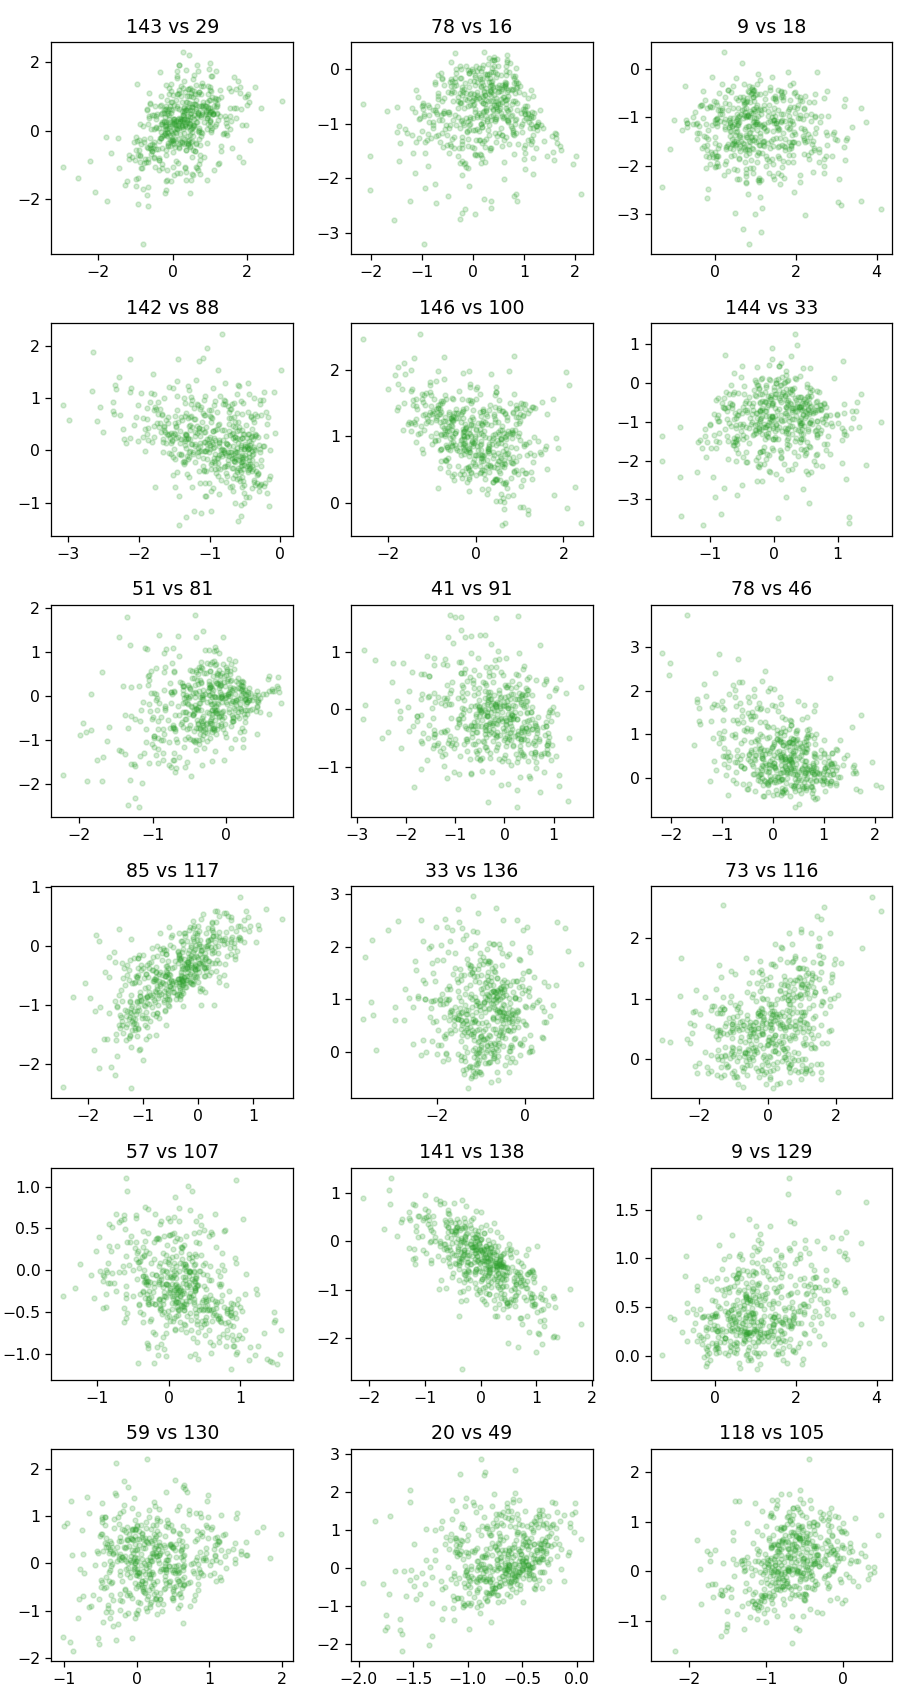

In [54]:
import matplotlib.pyplot as plt
%matplotlib notebook

theta =Hyper_Nets.sample(500).cpu().detach().numpy()


fig, axs = plt.subplots(6, 3,figsize=(8,15))
for k in range(6):
    for l in range(3):
        i=np.random.choice(a=np.arange(param_count), size=2,replace=False)
        axs[k, l].set(title=str(i[0])+' vs '+str(i[1]))
        for c in range(Hyper_Nets.nb_comp):
            axs[k, l].scatter(theta[c,:,i[0]],theta[c,:,i[1]],marker='.',alpha=0.2,color='C'+str(c+2))
        

fig.tight_layout()

<IPython.core.display.Javascript object>


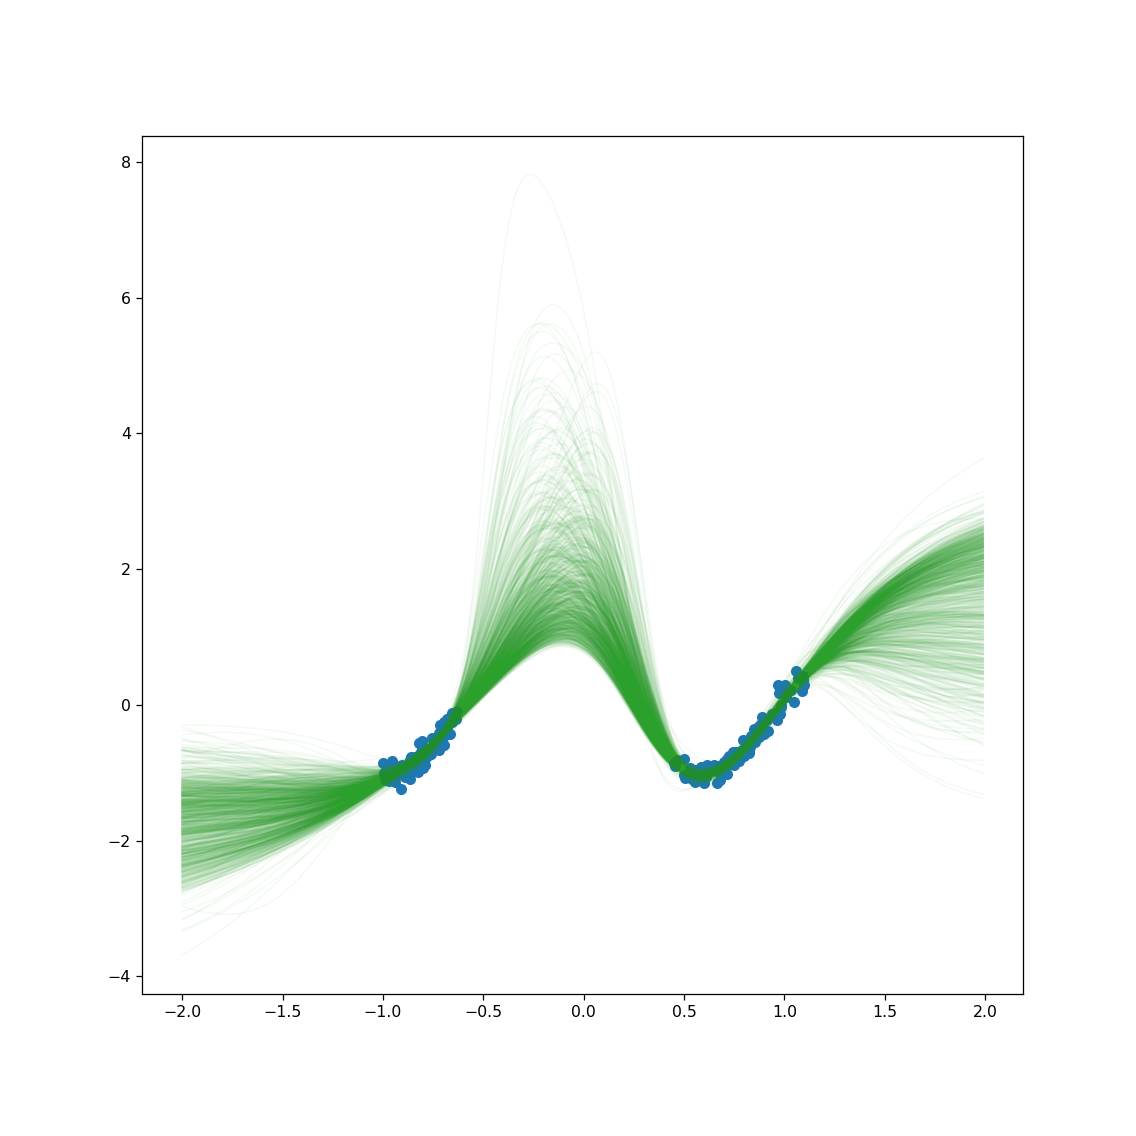

In [73]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook

x_lin = torch.arange(-2.,2.0,.01).unsqueeze(1).to(device)
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
#plt.title('Prior')
#ax.set_ylim(-4,4)

plt.scatter(x_train.cpu(), y_train.cpu())

nb_samples_plt=1000
theta = Hyper_Nets.sample(nb_samples_plt).detach()
for c in range(Hyper_Nets.nb_comp):
    for i in range(nb_samples_plt):
        y_pred = mlp(x_lin,theta[c,i].unsqueeze(0))
    #    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='green')
        plt.plot(x_lin.detach().cpu().numpy(), y_pred.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='C'+str(c+2))
    

# Entropy estimation #

In [56]:
def KDE(x,y,prec):
    """
    KDE    
    
    Parameters:
        x (Tensor): Inputs, NbExemples X NbDimensions   
        y (Tensor):  Batched samples, NbBatch x NbSamples X NbDimensions
        prec (Float): scalar factor for bandwidth scaling
    

    Returns:
        (Tensor) KDE estimate for x based on batched diagonal "Silverman's rule of thumb", NbExemples X 1
        See Wand and Jones p.111 "Kernel Smoothing" 1995.  
    
    """
    
    dim=x.shape[-1]
    n_ed=x.shape[0]
    n_comp=y.shape[0]
    n_kde=y.shape[1]
    c_=(n_kde*(dim+2))/4
    c=torch.as_tensor(c_).pow(2/(dim+4)).to(device)  
    H=prec*(y.var(1)/c).clamp(torch.finfo().eps,float('inf'))

    d=((y.view(n_comp,n_kde,1,dim)-x.view(1,1,n_ed,dim))**2)
    H_=H.view(n_comp,dim,1,1).inverse().view(n_comp,1,1,dim)
    const=0.5*H.log().sum(1)+0.5*dim*torch.tensor(2*math.pi).log()
    const=const.view(n_comp,1,1)
    ln=-0.5*(H_*d).sum(3)-const
    N=torch.as_tensor(float(n_comp*n_kde),device=device)
    return (ln.logsumexp(0).logsumexp(0)-torch.log(N)).unsqueeze(-1)


def NNE(theta,k=1):
    """
    Parameters:
        theta (Tensor): Samples, NbExemples X NbDimensions   
        k (Int): ordinal number

    Returns:
        (Float) k-Nearest Neighbour Estimation of the entropy of theta  
    
    """
    nb_samples=theta.shape[0]
    dim=theta.shape[1]
    D=torch.cdist(theta,theta)
    a = torch.topk(D, k=k+1, dim=0, largest=False, sorted=True)[0][k].clamp(torch.finfo().eps,float('inf')).to(device)
    d=torch.as_tensor(float(dim),device=device)
    K=torch.as_tensor(float(k),device=device)
    N=torch.as_tensor(float(nb_samples),device=device)
    pi=torch.as_tensor(math.pi,device=device)
    lcd = d/2.*pi.log() - torch.lgamma(1. + d/2.0)
    return torch.digamma(N) - torch.digamma(K) + lcd + d/nb_samples*torch.sum(torch.log(a))

In [57]:
"""
Example of density estimation on Multivariate Normal

dim=100
p=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(dim), torch.diagflat(2.*torch.ones(dim)))
print(p.entropy())
print(-KDE(p.sample((1,1000)).squeeze(0), p.sample((1,1000)),1.).mean())
print(NNE(p.sample((1,1000)).squeeze(0)))
"""

'\nExample of density estimation on Multivariate Normal\n\ndim=100\np=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(dim), torch.diagflat(2.*torch.ones(dim)))\nprint(p.entropy())\nprint(-KDE(p.sample((1,1000)).squeeze(0), p.sample((1,1000)),1.).mean())\nprint(NNE(p.sample((1,1000)).squeeze(0)))\n'

# Metrics #

In [58]:
# the average negative log predictive density (NLPD) of the true targets

def NLPD(theta, x, y, sigma_noise):
    y_pred = mlp(x, theta)
    L = _log_norm(y_pred, y, torch.tensor([sigma_noise], device=device))
    n_x = torch.as_tensor(float(x.shape[0]), device=device)
    n_theta = torch.as_tensor(float(theta.shape[0]), device=device)
    log_posterior_predictive = torch.logsumexp(L, 0) - torch.log(n_theta)
    return torch.mean(-log_posterior_predictive)

In [60]:
NLPD(Hyper_Nets(100),x_test,y_test,sigma_noise)

tensor(2.1858, device='cuda:0', grad_fn=<MeanBackward0>)

In [61]:
def RMSE(theta,x,y):
    n_samples=x.shape[0]
    y_pred = mlp(x, theta).mean(0)
    mse=(y_pred-y.view(n_samples,1))**2
    return mse.mean().sqrt()

In [63]:
RMSE(Hyper_Nets(100),x_test,y_test)

tensor(1.2308, device='cuda:0', grad_fn=<SqrtBackward>)

# Training #

In [64]:
KDE_prec=1.
n_samples_KDE=100
n_samples_NNE=1000
n_samples_ED=10
n_samples_LP=10
max_iter=10000000
learning_rate=0.005
min_lr=0.00000005
patience=500
lr_decay=0.9
param_count

151

In [65]:
-KDE(Hyper_Nets(n_samples_ED),Hyper_Nets.sample(n_samples_KDE),KDE_prec).mean()

tensor(83.8100, device='cuda:0', grad_fn=<NegBackward>)

In [66]:
NNE(Hyper_Nets(n_samples_NNE),1)

tensor(-15.2795, device='cuda:0', grad_fn=<AddBackward0>)

In [67]:
optimizer = torch.optim.Adam(Hyper_Nets.parameters(), lr=learning_rate)
        
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay)


In [68]:
from livelossplot import PlotLosses

%matplotlib inline

liveloss = PlotLosses()

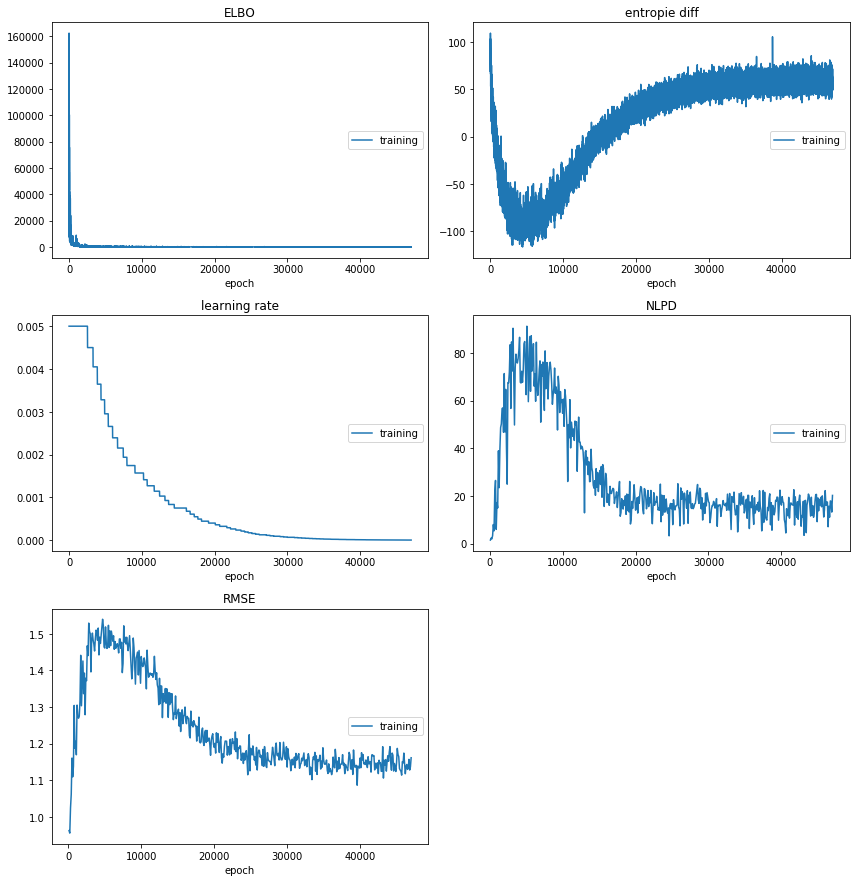

ELBO:
training   (min:  -66.608, max: 175104.875, cur:  -42.147)

entropie diff:
training   (min: -116.383, max:  109.097, cur:   49.024)

learning rate:
training   (min:    0.000, max:    0.005, cur:    0.000)

NLPD:
training   (min:    1.498, max:   91.292, cur:   20.238)

RMSE:
training   (min:    0.956, max:    1.540, cur:    1.162)


KeyboardInterrupt: 

In [70]:
%matplotlib inline


        
for t in range(max_iter):
    optimizer.zero_grad()
    logs = {}


#KDE:    
    ED=-KDE(Hyper_Nets(n_samples_ED),Hyper_Nets.sample(n_samples_KDE),KDE_prec).mean()
#Nearest Neighbour Entropy estimation
#    ED=NNE(Hyper_Nets(n_samples_NNE))
    LP=logtarget(Hyper_Nets(n_samples_LP)).mean()
    L =-ED-LP

    L.backward()

    #training_loss.append(L.detach().clone().cpu().numpy())

    lr = optimizer.param_groups[0]['lr']

    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['entropie diff'] = ED.detach().clone().cpu().numpy()
    logs['learning rate'] = lr
    if t % 100 == 0:
        logs['NLPD'] = NLPD(Hyper_Nets(100),x_test,y_test,sigma_noise).detach().clone().cpu().numpy()
        logs['RMSE'] = RMSE(Hyper_Nets(100),x_test,y_test).detach().clone().cpu().numpy()
    liveloss.update(logs)
        
        
    scheduler.step(L.detach().clone().cpu().numpy())

    optimizer.step()
    
    if t % 1000 == 0:
        
        liveloss.draw()




    if lr < min_lr:
        break

